In [1]:
import pandas as pd

with open('data/divemt/data/processed/ita/t1_main.tsv', 'r') as in_file:
    mmh = pd.read_csv(in_file, delimiter='\t')
    i = 0

In [2]:
import pandas as pd

with open('data/divemt/data/processed/ita/t1_main_texts.tsv', 'r') as in_file:
    aaa = pd.read_csv(in_file, delimiter='\t')

In [3]:
okcool = pd.concat((mmh, aaa['mt_text'], aaa['tgt_text'], aaa['src_text']), axis=1).dropna()

In [ ]:
import rsatoolbox

import numpy as np
from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt

from torch import eye, matmul, Tensor
from torch.nn.functional import pad

from rsatoolbox.vis.rdm_plot import show_rdm
from rsatoolbox.rdm.rdms import RDMs

from scipy.stats import weightedtau

def project_embedding(embeddings: Tensor, dim : int =2, start=0):
    projectionMatrix = pad(eye(dim), (0, embeddings.shape[0], start, (embeddings.shape[1] - start) - dim), value=0)

    result = matmul(embeddings, projectionMatrix)[:, :dim]

    return result.numpy(force=True)

def list_to_symm_matrix(in_list, dim):
    tri = np.zeros((dim, dim))
    tri[np.triu_indices(dim, 1)] = in_list
    tri[np.tril_indices(dim, -1)] = in_list
    
    return tri

def calc_score(tokenizer_out, model_out, input, tokenizer_ref=None, model_ref=None, attn=False):
    if tokenizer_ref is None or model_ref is None:
        tokenizer_ref = tokenizer_out
        model_ref = model_out
        ref = "tgt_text"
    else:
        ref = "src_text"

    la_example_out = tokenizer_out(okcool['mt_text'][input], return_tensors='pt', padding='max_length', truncation=True, max_length=50)
    la_example_ref = tokenizer_ref(okcool[ref][input], return_tensors='pt', padding='max_length', truncation=True, max_length=50)

    labels_out = [tokenizer_out.decode(i.item()) for i in la_example_out['input_ids'][0]]
    labels_ref = [tokenizer_ref.decode(i.item()) for i in la_example_ref['input_ids'][0]]

    max_len = max(len([i for i in labels_out if i != "[PAD]"]), len([i for i in labels_ref if i != "[PAD]"]))

    labels_out = labels_out[:max_len]
    labels_ref = labels_ref[:max_len]

    mdl_out = model_out(**la_example_out, output_hidden_states=True, output_attentions=True)
    mdl_ref = model_ref(**la_example_ref, output_hidden_states=True, output_attentions=True)

    if not attn:
        embeddings_out = mdl_out['hidden_states'][0][0][:max_len]
        embeddings_ref = mdl_ref['hidden_states'][0][0][:max_len]

    else:
        embeddings_out = mdl_out['attentions'][0][0][:max_len].mean(dim=0)
        embeddings_ref = mdl_ref['attentions'][0][0][:max_len].mean(dim=0)

    rand_dim = np.random.randint(low=0, high=embeddings_out.shape[1] - 2)

    projection_out = project_embedding(embeddings_out, start=rand_dim)
    projection_ref = project_embedding(embeddings_ref, start=rand_dim)

    rdm_out = rsatoolbox.rdm.calc_rdm(rsatoolbox.data.Dataset(embeddings_out.detach().numpy()))
    rdm_ref = rsatoolbox.rdm.calc_rdm(rsatoolbox.data.Dataset(embeddings_ref.detach().numpy()))

    rdm_out.pattern_descriptors = {'index': labels_out}
    rdm_ref.pattern_descriptors = {'index': labels_ref}

    # rdm_out.append(rdm_ref)
    rankmask = [[0 if 
                    (rdm_out.pattern_descriptors["index"][i] == '[PAD]') ^ (rdm_ref.pattern_descriptors["index"][j] == '[PAD]') 
                else 
                    1 
                for j in range(max_len)] for i in range(max_len)]
    
    # show_rdm(rdm_out, pattern_descriptor='index', figsize=(10,10))

    full_rdm_out = list_to_symm_matrix(rdm_out.dissimilarities, max_len)
    full_rdm_ref = list_to_symm_matrix(rdm_ref.dissimilarities, max_len)

    result = weightedtau(full_rdm_out, full_rdm_ref, rank=rankmask, weigher=lambda x: x)

    return result, rdm_out, rdm_ref, projection_out, projection_ref, labels_out, labels_ref

: 

In [ ]:
import random as rd
from tqdm import tqdm

tokenizer_it = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-uncased")
tokenizer_en = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model_it = AutoModel.from_pretrained("dbmdz/bert-base-italian-uncased")
model_en = AutoModel.from_pretrained("google-bert/bert-base-uncased")

similarities = []
scores = []

okcool['edits_per_word'] = okcool['tot_edits'] / okcool['mt_len_wrd']
okcool['edits_per_chr'] = okcool['tot_edits'] / okcool['mt_len_chr']

y_axis = 'time_per_word'

for m in tqdm(okcool.index.values):
    # rand_i = rd.choice(okcool.index)

    result, rdm_out, rdm_ref, projection_out, projection_ref, labels_out, labels_ref = calc_score(tokenizer_it, model_it, m, tokenizer_ref=tokenizer_en, model_ref=model_en, attn=False)

    # out_x = projection_out[:, 0]
    # out_y = projection_out[:, 1]

    # ref_x = projection_ref[:, 0]
    # ref_y = projection_ref[:, 1]

    # ax.scatter(out_x, out_y, c='orange')
    # ax.scatter(ref_x, ref_y, c='purple')

    # for i, txt in enumerate(labels_out):
    #     ax.annotate(txt, (out_x[i], out_y[i]))

    # for i, txt in enumerate(labels_ref):
    #     ax.annotate(txt, (ref_x[i], ref_y[i]))

    # print(f"similarity:\t\t{result.statistic}")
    # print(f"actual score:\t\t{okcool['words_per_minute'][rand_i]}")
    # print()

    # if result.statistic != 1 and okcool['time_per_word'][rand_i] <= 100 and "ht" not in okcool["unit_id"][rand_i]:
    similarities.append(result.statistic)
    scores.append(okcool[y_axis][m])


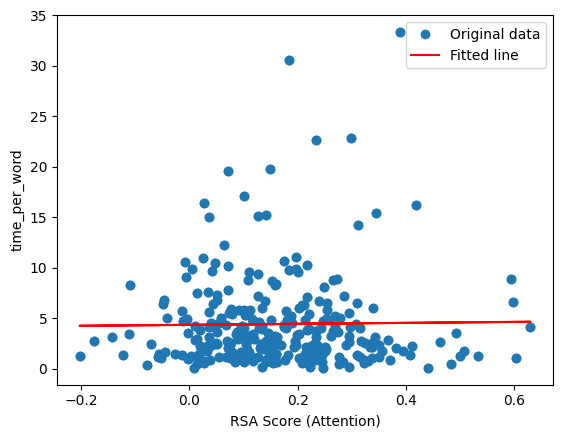

In [34]:
fig, ax = plt.subplots()

similarities = np.array(similarities)
scores = np.array(scores)

ax.set_xlabel("RSA Score (Attention)")
ax.set_ylabel(y_axis)

if len(similarities.shape) != 1:
    similarities = similarities[:, 0, 0]

A = np.vstack([similarities, np.ones(similarities.shape[0])]).T
m, c = np.linalg.lstsq(A, scores)[0]

_ = plt.plot(similarities, scores, 'o', label='Original data')
_ = plt.plot(similarities, m*similarities + c, 'r', label='Fitted line')
_ = plt.legend()

ax.scatter(similarities, scores)

# show_rdm(rdm_out, pattern_descriptor='index', figsize=(10,10))
# show_rdm(rdm_ref, pattern_descriptor='index', figsize=(10,10))

plt.show()

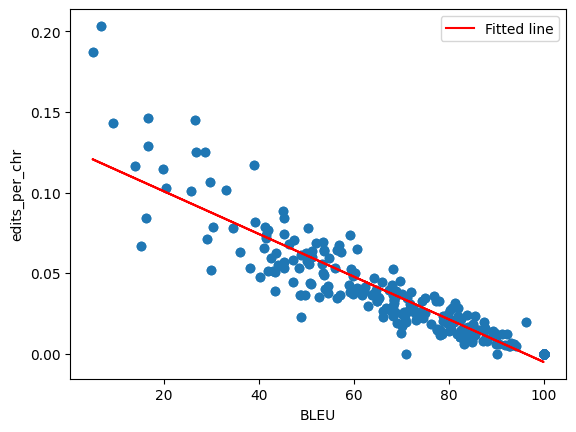

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(y_axis)
# ax.set_ylim(0, 100)

ax.set_xlabel("BLEU")
# ax.set_xlim(0, 99)

x = okcool['bleu']
y = okcool[y_axis]

A = np.vstack([x, np.ones(x.shape[0])]).T
m, c = np.linalg.lstsq(A, y)[0]

ax.scatter(x, y)

_ = plt.plot(x, y, 'o')
_ = plt.plot(x, m*x + c, 'r', label='Fitted line')
_ = plt.legend()

In [ ]:
from bert_score import score

bertscores = score(list(okcool['mt_text']), list(okcool['tgt_text']), lang="it", verbose=True)


calculating scores...
computing bert embedding.


100%|██████████| 8/8 [00:01<00:00,  6.73it/s]


computing greedy matching.


100%|██████████| 5/5 [00:00<00:00, 21.63it/s]

done in 1.52 seconds, 181.68 sentences/sec


In [ ]:
from evaluate import load
bertscore = load("bertscore")
results = [bertscore.compute(predictions=[mt], references=[tgt], lang="en")['f1'] for mt, tgt in tqdm(list(zip(okcool['mt_text'], okcool['tgt_text'])))]
results = np.ravel(results)

  0%|          | 0/276 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 276/276 [00:15<00:00, 18.09it/s]


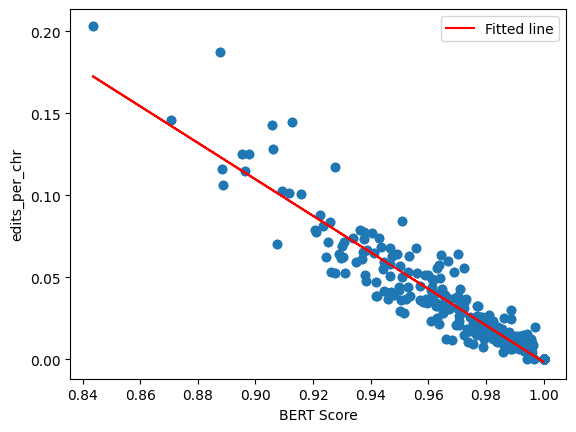

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(y_axis)
# ax.set_ylim(0, 100)

ax.set_xlabel("BERT Score")
# ax.set_xlim(0, 99)

x = results
y = okcool[y_axis]

A = np.vstack([x, np.ones(x.shape[0])]).T
m, c = np.linalg.lstsq(A, y)[0]

ax.scatter(x, y)

_ = plt.plot(x, y, 'o')
_ = plt.plot(x, m*x + c, 'r', label='Fitted line')
_ = plt.legend()